<center><h1>Geng_Haoxiang_HW4</h1></center>
<br>
<br>

Name: Haoxiang Geng
<br>
Github Username: Haoxiang310
<br>
USC ID: 8045015278

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [78]:
import os
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc, 
    roc_auc_score, 
    accuracy_score
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import statsmodels.api as sm

Get the AReM Data Set

In [79]:
folder_paths = {
    'bending1': '../data/AReM/bending1',
    'bending2': '../data/AReM/bending2',
    'cycling': '../data/AReM/cycling',
    'lying': '../data/AReM/lying',
    'sitting': '../data/AReM/sitting',
    'standing': '../data/AReM/standing',
    'walking': '../data/AReM/walking'
}

sniffer = csv.Sniffer()

def get_datasets_in_folder(folder_path):
    datasets = os.listdir(folder_path)
    datasets.sort(key=lambda x: int(x.split('dataset')[1].split('.')[0]))
    return datasets
        
columns = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

#fix the error dataset(cycling/dataset9.csv and cycling/dataset14.csv)
def fix_error_dataset(dataset_path):
    if "cycling/dataset9.csv" in dataset_path or "cycling/dataset14.csv" in dataset_path:
        with open(dataset_path, 'r') as f:
            lines = f.readlines()

        if lines and lines[-1].endswith(","):
            lines[-1] = lines[-1][:-1]
        
        with open(dataset_path, 'w') as f:
            f.writelines(lines)

def read_dataset_file(dataset_path):
    fix_error_dataset(dataset_path)
    if 'bending2/dataset4' in dataset_path:
        delimiter = '\s+'
    else:
        delimiter = ','
    data = pd.read_csv(dataset_path, sep=delimiter, skiprows=5, header=None, names=columns)
    data['label'] = os.path.basename(os.path.dirname(dataset_path))
    return data


### (b) Splitting Data

In [80]:
test_data = []
train_data = []
test_data_paths = []
train_data_paths = []

for folder, path in folder_paths.items():
    datasets = get_datasets_in_folder(path)
    if folder in ['bending1', 'bending2']:
        test_datasets = datasets[0:2]
    else:
        test_datasets = datasets[0:3]

    for dataset in datasets:
        dataset_path = os.path.join(path, dataset)
        data = read_dataset_file(dataset_path)
        
        if data is not None:
            dataset_name = os.path.join(folder, dataset)
            if dataset in test_datasets:
#                 print(f"Test data for {dataset_name}:","\n", data)
                test_data.append(data)
                test_data_paths.append(dataset_name)  
            else:
#                 print(f"Train data for {dataset_name}:","\n", data)
                train_data.append(data)
                train_data_paths.append(dataset_name)

print("Datasets in train set:",train_data_paths)
print("Datasets in test set:",test_data_paths)

Datasets in train set: ['bending1/dataset3.csv', 'bending1/dataset4.csv', 'bending1/dataset5.csv', 'bending1/dataset6.csv', 'bending1/dataset7.csv', 'bending2/dataset3.csv', 'bending2/dataset4.csv', 'bending2/dataset5.csv', 'bending2/dataset6.csv', 'cycling/dataset4.csv', 'cycling/dataset5.csv', 'cycling/dataset6.csv', 'cycling/dataset7.csv', 'cycling/dataset8.csv', 'cycling/dataset9.csv', 'cycling/dataset10.csv', 'cycling/dataset11.csv', 'cycling/dataset12.csv', 'cycling/dataset13.csv', 'cycling/dataset14.csv', 'cycling/dataset15.csv', 'lying/dataset4.csv', 'lying/dataset5.csv', 'lying/dataset6.csv', 'lying/dataset7.csv', 'lying/dataset8.csv', 'lying/dataset9.csv', 'lying/dataset10.csv', 'lying/dataset11.csv', 'lying/dataset12.csv', 'lying/dataset13.csv', 'lying/dataset14.csv', 'lying/dataset15.csv', 'sitting/dataset4.csv', 'sitting/dataset5.csv', 'sitting/dataset6.csv', 'sitting/dataset7.csv', 'sitting/dataset8.csv', 'sitting/dataset9.csv', 'sitting/dataset10.csv', 'sitting/dataset11

### (c) Feature Extraction

In [81]:
def extract_features_with_label(data, data_paths):
    extracted_features = []
    labels = []
    
    for idx, instance in enumerate(data):
        extracted_feature_values = []
        for column in columns[1:]:
            extracted_feature_values.extend([
                instance[column].min(),
                instance[column].max(),
                instance[column].mean(),
                instance[column].median(),
                instance[column].std(),
                instance[column].quantile(0.25),
                instance[column].quantile(0.75)
            ])
        extracted_features.append(extracted_feature_values)
        
        # Extract the label from the data path (folder name)
        label = os.path.dirname(data_paths[idx]).split(os.path.sep)[-1]
        labels.append(label)
        
    return extracted_features, labels

# Extract features and labels
stats_features = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
new_train_data, train_labels = extract_features_with_label(train_data, train_data_paths)
new_test_data, test_labels = extract_features_with_label(test_data, test_data_paths)
new_columns = [f"{stats_feature}{i}" for i in range(1, 7) for stats_feature in stats_features]

# Create dataframes
train_set_df = pd.DataFrame(new_train_data, columns=new_columns)
train_set_df['label'] = train_labels

test_set_df = pd.DataFrame(new_test_data, columns=new_columns)
test_set_df['label'] = test_labels

# Combine dataframes
combined_df = pd.concat([train_set_df, test_set_df], axis=0).reset_index(drop=True)

# print("Extraced features with labels are:\n", test_set_df)
combined_df

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.500,0.0,1.79,0.493292,0.430,0.513506,0.000,0.940,bending1
1,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.330,0.0,2.18,0.613521,0.500,0.524317,0.000,1.000,bending1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.250,0.0,1.79,0.383292,0.430,0.389164,0.000,0.500,bending1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.000,0.0,5.26,0.679646,0.500,0.622534,0.430,0.870,bending1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.750,0.0,2.96,0.555312,0.490,0.487826,0.000,0.830,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,35.50,46.25,43.174938,43.670,1.989052,42.50,44.5000,0.0,2.12,0.506583,...,12.7500,16.500,0.0,5.72,0.911979,0.830,0.666161,0.470,1.220,standing
84,32.75,47.00,42.760562,44.500,3.398919,41.33,45.3725,0.0,3.34,0.486167,...,13.0000,18.565,0.0,5.73,0.842271,0.710,0.722165,0.430,1.090,standing
85,19.33,43.50,34.227771,35.500,4.889576,30.50,37.7500,0.0,14.50,3.995729,...,14.7500,18.670,0.0,9.74,3.394125,3.100,1.792090,2.105,4.425,walking
86,12.50,45.00,33.509729,34.125,4.850923,30.50,36.7500,0.0,13.05,4.450771,...,14.6275,18.750,0.0,8.96,3.378479,3.085,1.787360,2.060,4.440,walking


## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

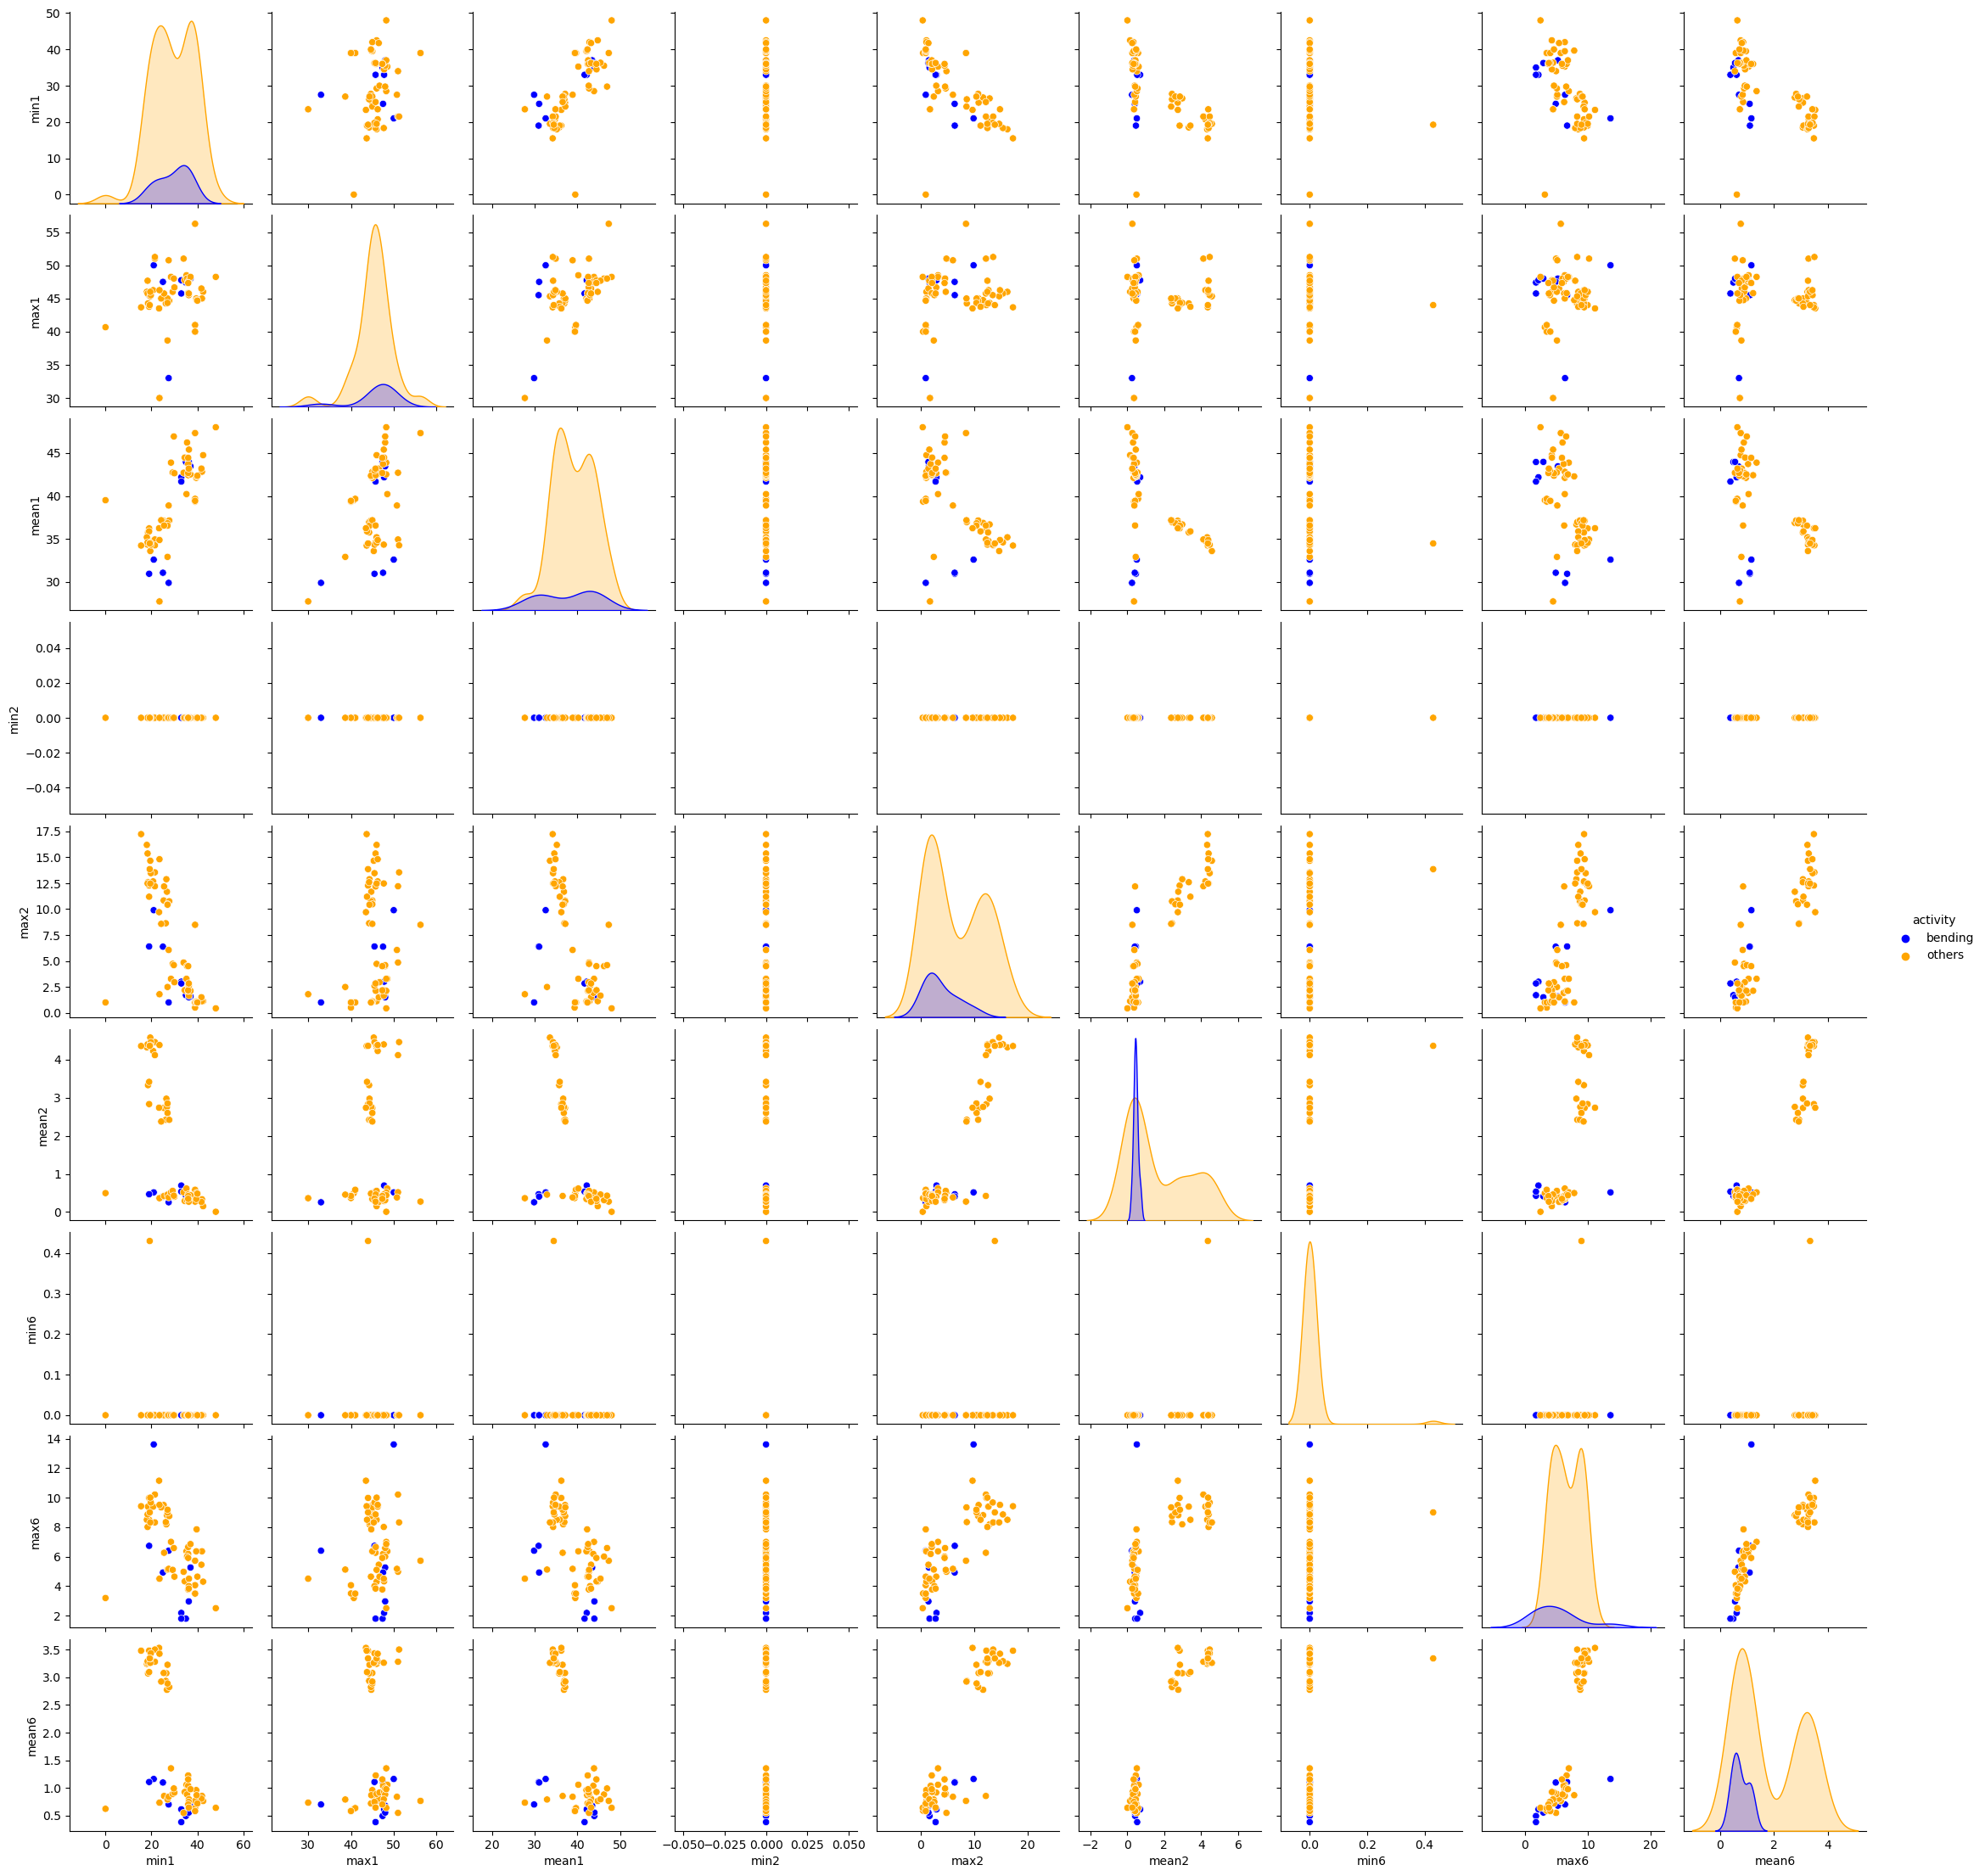

In [82]:
def time_series_scatter_plot(dataframe, idxs, features=['min', 'max', 'mean']):
    columns = []
    for idx in idxs:
        for feature in features:
            column_name = feature + str(idx)
            columns.append(column_name)
    temp = dataframe
    temp['activity'] = 'others'
    temp.loc[dataframe['label'].isin(['bending1', 'bending2']), 'activity'] = 'bending'    
    sns.pairplot(temp, hue='activity', vars=columns, palette={'bending': 'blue', 'others': 'orange'})
    plt.show()

time_series_scatter_plot(train_set_df,[1,2,6])

#### ii. Splitted Plots

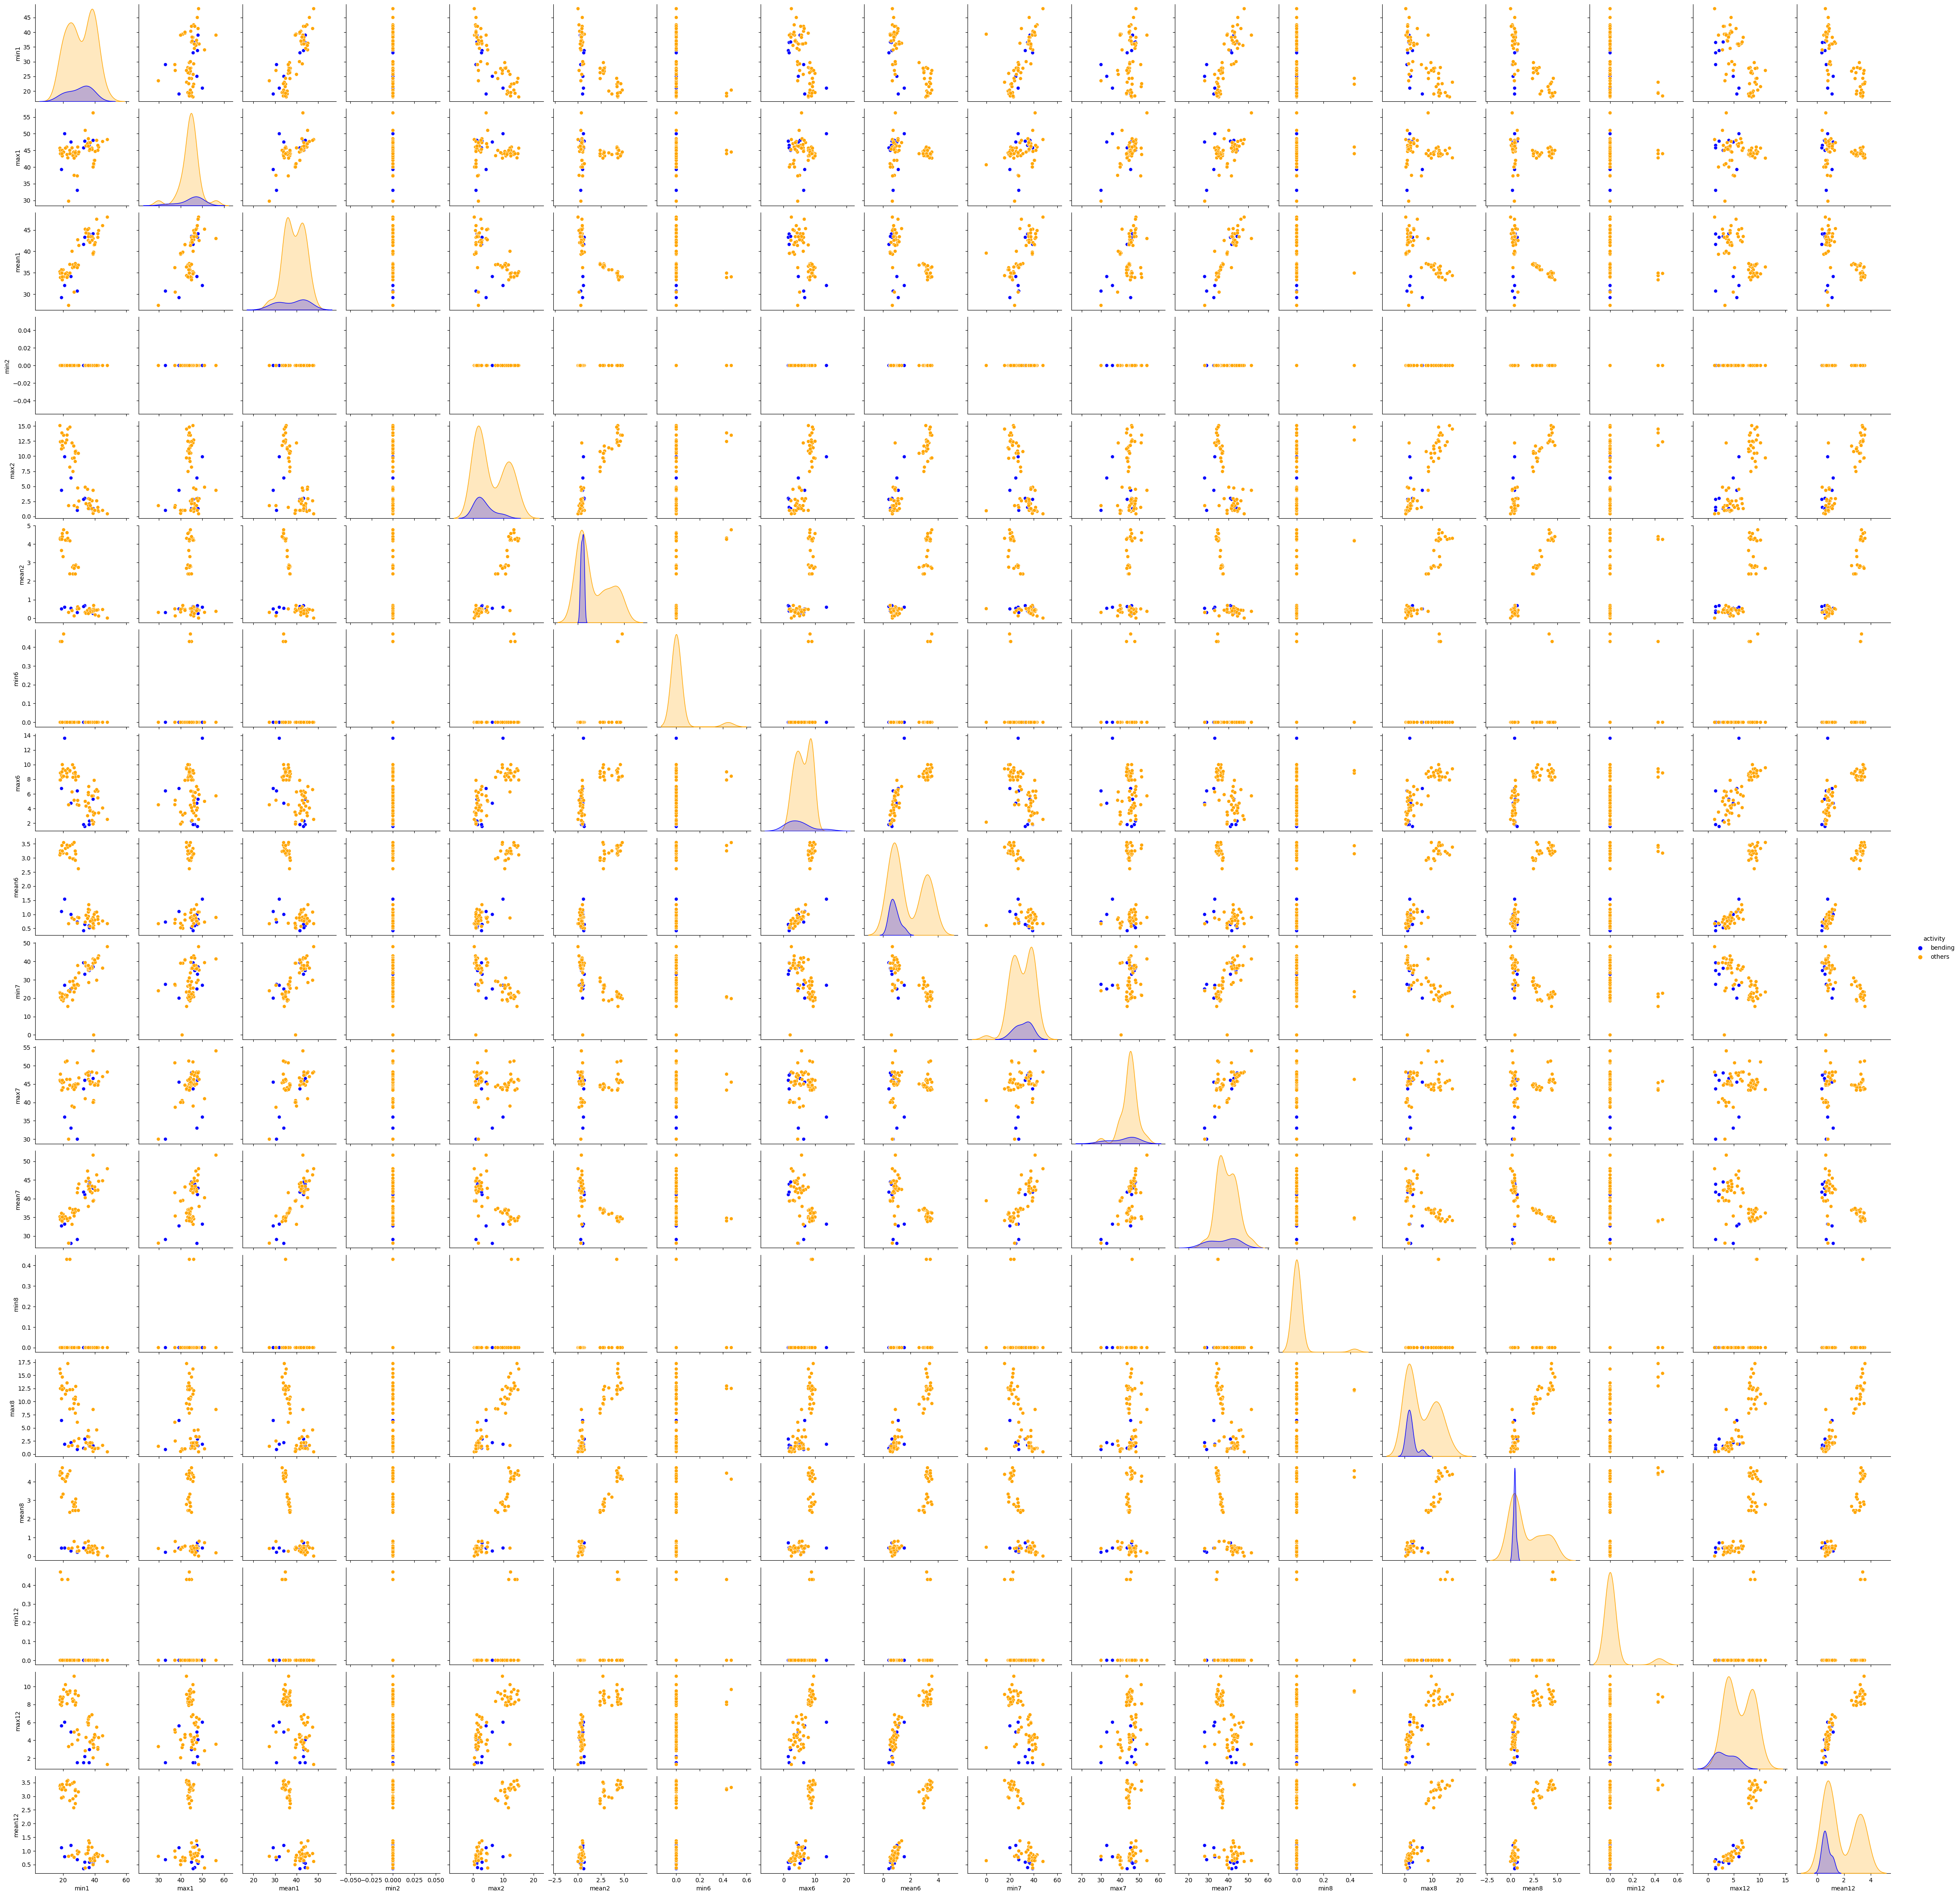

In [83]:
split_training_set = [(df.iloc[:240], df.iloc[-240:]) for df in train_data]

def compute_statistics_for_two_segments(dataframe1, dataframe2, new_stats_columns):
    stats_result = []
    for df in [dataframe1, dataframe2]:
        for new_stats_column in new_stats_columns:
            stats_result.extend([
                df[new_stats_column].min(),
                df[new_stats_column].max(),
                df[new_stats_column].mean(),
                df[new_stats_column].median(),
                df[new_stats_column].std(),
                df[new_stats_column].quantile(0.25),
                df[new_stats_column].quantile(0.75)
            ])
    stats_result.append(dataframe1['label'].iloc[0])
    return stats_result

new_stats_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

result_stats_columns = []
for i in range(1, len(new_stats_columns) * 2 + 1): 
    result_stats_columns.extend([
        f"min{i}",
        f"max{i}",
        f"mean{i}",
        f"median{i}",
        f"std{i}",
        f"1st_quartile{i}",
        f"3rd_quartile{i}",
    ])
result_stats_columns.append('label')
result_stats_dataframe = pd.DataFrame(columns=result_stats_columns)
for i in range(0, len(split_training_set)):
    combined_stats = compute_statistics_for_two_segments(split_training_set[i][0], split_training_set[i][1], new_stats_columns)
    #generate new row based on result_stats_columns
    cur_row = pd.Series(combined_stats, index=result_stats_columns)
    result_stats_dataframe = pd.concat([result_stats_dataframe, cur_row.to_frame().T], ignore_index=True)

# print(result_df)
time_series_scatter_plot(result_stats_dataframe, [1,2,6,7,8,12])

**Except for the splitting of the training set led to a more refined representation due to the increased number of plots， there are no significant difference between the results in 2(a)i and 2(a)ii.**

#### iii. Time Series Segments

In [84]:
#helper function to generate statistic data for 1 seg
def compute_stats(seg):
    stats = []
    for column in seg.columns:
        if column not in ['time', 'label']:  
            stats.extend([
                seg[column].min(),
                seg[column].max(),
                seg[column].mean(),
                seg[column].median(),
                seg[column].std(),
                seg[column].quantile(0.25),
                seg[column].quantile(0.75)
            ])
    return stats

#helper function to generate statistic data based on specific l value
def generate_stats_of_lval(dataset_paths, lvalue=1):
    training_data = []
    for dataset_path in dataset_paths:
        full_path = os.path.abspath(os.path.join('../data/AReM', dataset_path))
        fix_error_dataset(full_path)
        if 'bending2/dataset4' in full_path:
            delimiter = '\s+'
        else:
            delimiter = ','
        data = pd.read_csv(full_path, sep=delimiter, skiprows=5, header=None, names=columns)
        rows_per_lvalue = len(data) // lvalue
        stats_data_for_all_lvalues = []

        #Split data into segments and compute statistics for each segment
        for i in range(lvalue):
            seg = data.iloc[i * rows_per_lvalue: (i + 1) * rows_per_lvalue]
            stats_data_for_current_lvalue = compute_stats(seg)
            stats_data_for_all_lvalues.extend(stats_data_for_current_lvalue)

        stats_data_for_all_lvalues.append(os.path.basename(os.path.dirname(full_path)))
        training_data.append(stats_data_for_all_lvalues)

    feature_columns = [column for column in columns if column not in ['time', 'label']]  
    feature_names = []
    #generate feature names for results_df
    for lval in range(lvalue):
        for col in feature_columns:
            for stat in ["min", "max", "mean", "median", "std", "1st_quartile", "3rd_quartile"]:
                feature_names.append(f"{stat}{lval * len(feature_columns) + feature_columns.index(col) + 1}")

    feature_names.append('label')
    result_df = pd.DataFrame(training_data, columns=feature_names)
    return result_df

In [85]:
#helper function for separating bending with other labels for binary classification
def generate_binary_labels(dataframe):
    temp = dataframe['label']
    dataframe.loc[temp.isin(['bending1', 'bending2']), 'label'] = "1"
    dataframe.loc[temp != "1", 'label'] = "0"
    return dataframe

#helper function for separating features and response
def split_predictors_and_response(data):
    dataX = data.iloc[:, :-1]
    dataY = data.iloc[:, -1]
    return dataX, dataY

def logistic_regression_with_feature_selection(train_files, max_lvalue, fold_count, penalty=None):
    best_accuracy = 0
    best_l = None
    best_selector = None

    for lvalue in range(1, max_lvalue+1):
        print(f'Running Logistic Regression for l-value {lvalue}')
        train_set = generate_stats_of_lval(train_files, lvalue)
        train_set = generate_binary_labels(pd.DataFrame(train_set))
        
        trainX, trainY = split_predictors_and_response(train_set)
        solver = 'lbfgs'
        validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
        
        model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
        selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
        selector.fit(trainX, trainY)
        
        avg_acc = selector.cv_results_['mean_test_score'].mean()
        print(f"For l-value {lvalue}, best number of predictors: {selector.n_features_}, with accuracy: {avg_acc:.4f}")
        
        if avg_acc > best_accuracy:
            best_accuracy = avg_acc
            best_l = lvalue
            best_selector = selector

    return best_l, best_selector, best_accuracy

best_l, best_selector, best_accuracy = logistic_regression_with_feature_selection(train_files=train_data_paths, max_lvalue=20, fold_count=5)
print(f"Best l: {best_l}, Best number of features: {best_selector.n_features_}, Best accuracy:{best_accuracy}")

Running Logistic Regression for l-value 1
For l-value 1, best number of predictors: 5, with accuracy: 0.9838
Running Logistic Regression for l-value 2
For l-value 2, best number of predictors: 7, with accuracy: 0.9472
Running Logistic Regression for l-value 3
For l-value 3, best number of predictors: 10, with accuracy: 0.9530
Running Logistic Regression for l-value 4
For l-value 4, best number of predictors: 11, with accuracy: 0.9528
Running Logistic Regression for l-value 5
For l-value 5, best number of predictors: 1, with accuracy: 0.9452
Running Logistic Regression for l-value 6
For l-value 6, best number of predictors: 3, with accuracy: 0.9487
Running Logistic Regression for l-value 7
For l-value 7, best number of predictors: 3, with accuracy: 0.9491
Running Logistic Regression for l-value 8
For l-value 8, best number of predictors: 62, with accuracy: 0.9435
Running Logistic Regression for l-value 9
For l-value 9, best number of predictors: 5, with accuracy: 0.9322
Running Logistic

Explanation:    
- Right way: do backward selection along with cross validation. Since selecting predictors is a crucial part of building the model, and cross validation should contain full training. In this way, we're simulating real world data by shaking the training data. We can not do it before we do cross validation.   
- Wrong way: do backward selection before cross validation.

**iv. Confusion Matrix**

In [86]:
#get best l value and predictors during crossvalidation
#seperate train set
#refit the model using whole dataset
train_set = generate_stats_of_lval(train_data_paths, best_l)
train_set = generate_binary_labels(pd.DataFrame(train_set))
trainX, trainY = split_predictors_and_response(train_set)
#get selected features
selected_features = trainX.columns[best_selector.support_]
print(selected_features)
#use these features to train model
best_linear_regression_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)
best_linear_regression_model.fit(trainX[selected_features], trainY)

Index(['3rd_quartile1', 'max2', 'min5', 'max5', '1st_quartile5'], dtype='object')


LogisticRegression(max_iter=10000, penalty=None)

In [87]:
def get_model_summary(train_files_path, selected_features, best_l):
    train_set = generate_stats_of_lval(train_files_path, best_l)
    train_set = generate_binary_labels(pd.DataFrame(train_set))
    trainX, trainY = split_predictors_and_response(train_set)
    train_set_with_best_features = trainX.loc[:, selected_features]
    const_value = sm.add_constant(train_set_with_best_features.to_numpy(dtype=float))
    model = sm.Logit(trainY.astype(float), const_value)
    summary = model.fit(method='lbfgs').summary()
    return summary

print(get_model_summary(train_data_paths, selected_features, best_l))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.55012D+01

At iterate    1    f=  4.80082D-01    |proj g|=  3.39472D+00

At iterate    2    f=  4.20153D-01    |proj g|=  2.48922D+00

At iterate    3    f=  3.89059D-01    |proj g|=  4.90146D+00

At iterate    4    f=  3.58186D-01    |proj g|=  1.28949D+00

At iterate    5    f=  2.61206D-01    |proj g|=  1.42143D+00

At iterate    6    f=  1.44757D-01    |proj g|=  7.38064D-01

At iterate    7    f=  9.33322D-02    |proj g|=  3.74308D-01

At iterate    8    f=  4.93430D-02    |proj g|=  2.75418D-01

At iterate    9    f=  3.12891D-02    |proj g|=  3.34491D-01

At iterate   10    f=  1.96458D-02    |proj g|=  2.65585D-01

At iterate   11    f=  1.17410D-02    |proj g|=  1.56965D-01

At iterate   12    f=  6.70554D-03    |proj g|=  9.02667D-02

At iterate   13    f=  3.7

 This problem is unconstrained.


ate   20    f=  3.07744D-05    |proj g|=  8.26307D-05

At iterate   21    f=  1.68761D-05    |proj g|=  1.05279D-04

At iterate   22    f=  9.20995D-06    |proj g|=  1.25864D-04

At iterate   23    f=  4.95418D-06    |proj g|=  1.00681D-04

At iterate   24    f=  2.64254D-06    |proj g|=  6.88006D-05

At iterate   25    f=  1.39596D-06    |proj g|=  4.29499D-05

At iterate   26    f=  7.30373D-07    |proj g|=  2.52075D-05

At iterate   27    f=  3.78362D-07    |proj g|=  1.41318D-05

At iterate   28    f=  1.88859D-07    |proj g|=  7.11879D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     32      1    

In [88]:
#Predict on train set
trainY_pred = best_linear_regression_model.predict(trainX[selected_features])
confusion_matrix_training_set = confusion_matrix(trainY, trainY_pred)
print("Confusion Matrix for Trainin Set:")
print(confusion_matrix_training_set)

test_set = generate_stats_of_lval(test_data_paths, best_l)
test_set = generate_binary_labels(pd.DataFrame(test_set))
testX, testY = split_predictors_and_response(test_set)
#Predict on test set
testY_pred = best_linear_regression_model.predict(testX[selected_features])
confusion_matrix_test_set = confusion_matrix(testY, testY_pred)
print("Confusion Matrix for Test Set:")
print(confusion_matrix_test_set)

Confusion Matrix for Trainin Set:
[[60  0]
 [ 0  9]]
Confusion Matrix for Test Set:
[[15  0]
 [ 0  4]]


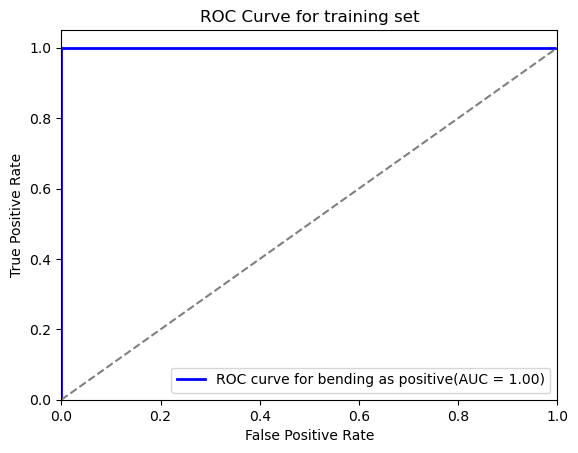

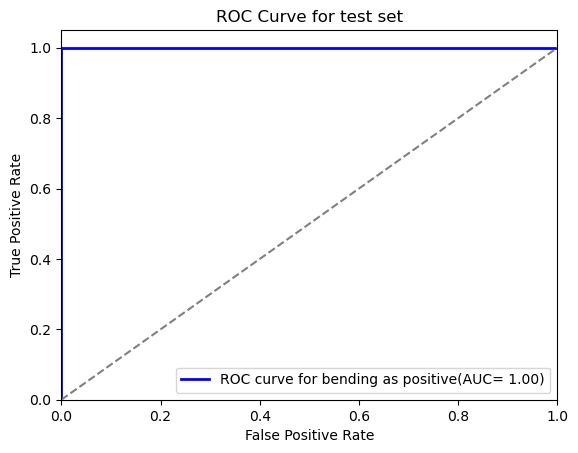

In [89]:
y_scores = best_linear_regression_model.decision_function(trainX[selected_features])
fpr, tpr, thresholds = roc_curve(trainY.astype(int), y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve for bending as positive(AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for training set')
plt.legend(loc="lower right")
plt.show()

#Bending as positive
y_scores = best_linear_regression_model.decision_function(testX[selected_features])
fpr, tpr, thresholds = roc_curve(testY.astype(int), y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve for bending as positive(AUC= %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for test set')
plt.legend(loc="lower right")
plt.show()

#### v. Test Classifier

In [90]:
#testX, testY are already extracted from testset based on best_l in former code block
testY_pred = best_linear_regression_model.predict(testX[selected_features])
testY_pred = testY_pred.astype(int)

print(testX[selected_features])

test_accuracy = accuracy_score(testY.astype(int), testY_pred)
print(f"Accuracy on the test set: {test_accuracy:.4f}")
print(f"Cross-validation accuracy:0.9838")

    3rd_quartile1   max2   min5   max5  1st_quartile5
0         42.0000   1.30  27.25  38.25        33.0000
1         43.6700   1.22  27.67  38.50        32.0000
2         26.5000   6.87  10.67  30.00        20.5000
3         30.0000   7.76   0.00  33.00        15.0000
4         40.2500   8.58   7.00  25.50        17.9500
5         40.2500   9.91  10.50  24.33        18.0000
6         40.0625  14.17   7.50  24.25        16.0000
7         29.0000   1.79   0.00  21.00         5.5000
8         48.0000   3.11   0.00  12.75         2.0000
9         48.0000   0.43   0.00  12.00         4.6700
10        43.5000   4.44   1.00  28.00        10.1875
11        46.5000   4.87   2.00  24.00        16.5000
12        45.3300   1.00   4.75  26.75        17.6275
13        46.5000   3.90   0.00  23.00         9.3300
14        44.5000   2.12   2.00  21.25        12.7500
15        45.3725   3.34   1.33  21.33        13.0000
16        37.7500  14.50   6.75  26.00        14.7500
17        36.7500  13.05   7

#### vi. Separation

The model reported that the dataset is well separated, and because logistic regression will be instable and algorithm cannot converge, the betas will continuing approaching infinity and p-value will get closer to 1. I solved it by setting the max_iter parameter to 100. In this case, although the p-value is not reliable, the model is acceptable. 

#### vii. Imbalance

According to my assignment, 0 = non-bending classes and 1 = bending classes. I can see, according to the confusion matrices, that there are 69 instances of non-bending classes and 9 instances for bending classes which goes to show that the classes are definitely imbalanced.

In [91]:
# Helper function for upsampling dataset
def upsampling(dataframe, randomstate):
    dataframe_majority = dataframe[dataframe.label=="0"]
    dataframe_minority = dataframe[dataframe.label=="1"]
    dataframe_minority_upsampled = dataframe_minority.sample(n=len(dataframe_majority), replace=True, random_state=randomstate)
    dataframe_upsampled = pd.concat([dataframe_majority, dataframe_minority_upsampled])
    return dataframe_upsampled


def logistic_regression(train_files, max_lvalue, fold_count, penalty=None, upsample = False):
    best_accuracy = 0
    best_l = None
    best_selector = None

    for l_value in range(1, max_lvalue+1):
        print(f'Running Logistic Regression for l-value {l_value}')
        train_set = generate_stats_of_lval(train_files, l_value)
        train_set = generate_binary_labels(pd.DataFrame(train_set))
        
        if(upsample):
            train_set = upsampling(train_set,60)
        trainX, trainY = split_predictors_and_response(train_set)
        solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
        validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
        model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
        selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
        selector.fit(trainX, trainY)
        avg_acc = selector.cv_results_['mean_test_score'].mean()
        print(f"For l-value {l_value}, best number of predictors: {selector.n_features_}, with accuracy: {avg_acc:.4f}")
        if avg_acc > best_accuracy:
            best_accuracy = avg_acc
            best_l = l_value
            best_selector = selector
    return best_l, best_selector, best_accuracy

best_l_upsampled, best_selector_upsampled, best_accuracy_upsampled = logistic_regression(train_files=train_data_paths, max_lvalue=20, fold_count=5, upsample=True)
print(f"Best l: {best_l_upsampled}, Best number of features: {best_selector_upsampled.n_features_}, Best accuracy:{best_accuracy_upsampled}")

Running Logistic Regression for l-value 1
For l-value 1, best number of predictors: 4, with accuracy: 0.9919
Running Logistic Regression for l-value 2
For l-value 2, best number of predictors: 6, with accuracy: 0.9792
Running Logistic Regression for l-value 3
For l-value 3, best number of predictors: 4, with accuracy: 0.9788
Running Logistic Regression for l-value 4
For l-value 4, best number of predictors: 14, with accuracy: 0.9821
Running Logistic Regression for l-value 5
For l-value 5, best number of predictors: 3, with accuracy: 0.9780
Running Logistic Regression for l-value 6
For l-value 6, best number of predictors: 3, with accuracy: 0.9771
Running Logistic Regression for l-value 7
For l-value 7, best number of predictors: 3, with accuracy: 0.9774
Running Logistic Regression for l-value 8
For l-value 8, best number of predictors: 4, with accuracy: 0.9766
Running Logistic Regression for l-value 9
For l-value 9, best number of predictors: 8, with accuracy: 0.9772
Running Logistic R

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.55012D+01

At iterate    1    f=  4.82997D-01    |proj g|=  3.40963D+00

At iterate    2    f=  4.24895D-01    |proj g|=  2.49696D+00

At iterate    3    f=  4.00578D-01    |proj g|=  4.33315D+00

At iterate    4    f=  3.77427D-01    |proj g|=  1.04978D+00

At iterate    5    f=  3.14249D-01    |proj g|=  1.20468D+00

At iterate    6    f=  1.32550D-01    |proj g|=  9.29884D-01

At iterate    7    f=  9.88669D-02    |proj g|=  6.99749D-01

At iterate    8    f=  6.23147D-02    |proj g|=  2.75448D-01

At iterate    9    f=  3.87421D-02    |proj g|=  1.04644D-01

At iterate   10    f=  2.26623D-02    |proj g|=  8.12165D-02

At iterate   11    f=  1.35852D-02    |proj g|=  6.20605D-02

At iterate   12    f=  8.40642D-03    |proj g|=  3.91271D-02

At iterate   13    f=  5.0

 This problem is unconstrained.


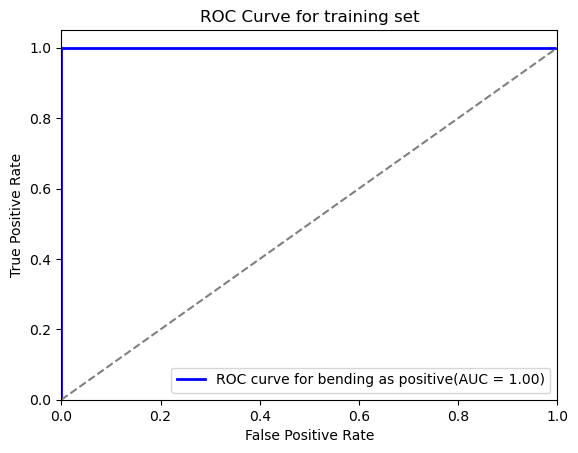

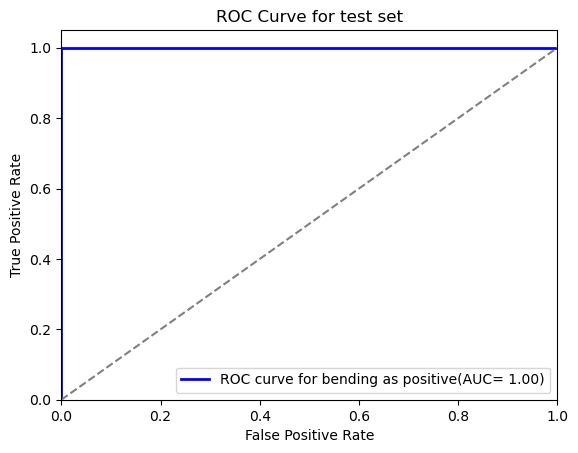

Confusion Matrix for Training Set:
[[60  0]
 [ 0 60]]
Confusion Matrix for Test Set:
[[15  0]
 [ 0 15]]


In [92]:
train_set = generate_stats_of_lval(train_data_paths, best_l_upsampled)
train_set = generate_binary_labels(pd.DataFrame(train_set))
train_set = upsampling(train_set,60)
trainX, trainY = split_predictors_and_response(train_set)

selected_features = best_selector_upsampled.support_
selected_features = trainX.columns[best_selector_upsampled.support_]
penalty = None
solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
best_linear_regression_model_with_upsampling = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
best_linear_regression_model_with_upsampling.fit(trainX[selected_features], trainY)

#get model summary
print(get_model_summary(train_data_paths, selected_features, best_l_upsampled))

#ROC curve for training set
y_scores = best_linear_regression_model_with_upsampling.decision_function(trainX[selected_features])
fpr, tpr, thresholds = roc_curve(trainY.astype(int), y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve for bending as positive(AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for training set')
plt.legend(loc="lower right")
plt.show()

#ROC curve for test set
y_scores = best_linear_regression_model_with_upsampling.decision_function(testX[selected_features])
fpr, tpr, thresholds = roc_curve(testY.astype(int), y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve for bending as positive(AUC= %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for test set')
plt.legend(loc="lower right")
plt.show()

#Confusion matrix for training set
trainY_pred = best_linear_regression_model_with_upsampling.predict(trainX[selected_features])
confusion_matrix_training_set = confusion_matrix(trainY, trainY_pred)
print("Confusion Matrix for Training Set:")
print(confusion_matrix_training_set)


#Confusion matrix for test set
test_set = generate_stats_of_lval(test_data_paths, best_l)
test_set = generate_binary_labels(pd.DataFrame(test_set))
test_set = upsampling(test_set,15)
testX, testY = split_predictors_and_response(test_set)

testY_pred = best_linear_regression_model_with_upsampling.predict(testX[selected_features])
confusion_matrix_test_set = confusion_matrix(testY, testY_pred)
print("Confusion Matrix for Test Set:")
print(confusion_matrix_test_set)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

Running L1 penalized logistic regression Cross-Validation for l-value 1
Running L1 penalized logistic regression Cross-Validation for l-value 2
Running L1 penalized logistic regression Cross-Validation for l-value 3
Running L1 penalized logistic regression Cross-Validation for l-value 4
Running L1 penalized logistic regression Cross-Validation for l-value 5
Running L1 penalized logistic regression Cross-Validation for l-value 6
Running L1 penalized logistic regression Cross-Validation for l-value 7
Running L1 penalized logistic regression Cross-Validation for l-value 8
Running L1 penalized logistic regression Cross-Validation for l-value 9
Running L1 penalized logistic regression Cross-Validation for l-value 10
Running L1 penalized logistic regression Cross-Validation for l-value 11
Running L1 penalized logistic regression Cross-Validation for l-value 12
Running L1 penalized logistic regression Cross-Validation for l-value 13
Running L1 penalized logistic regression Cross-Validation fo

 This problem is unconstrained.
/Users/akina/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


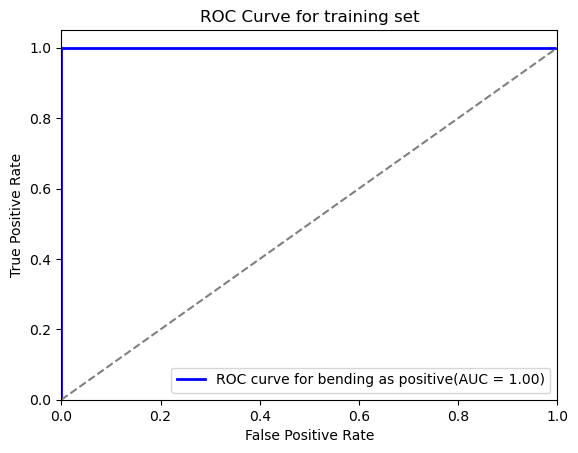

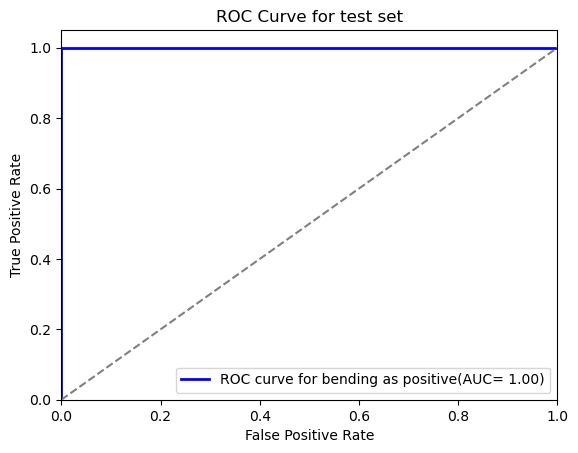

Confusion Matrix for Training Set:
[[60  0]
 [ 0  9]]
Confusion Matrix for Test Set:
[[15  0]
 [ 0  4]]


In [93]:
def plot_roc_curve(fpr, tpr, title):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def perform_binary_classification_with_l1_penalized(train_data_paths, test_data_paths, max_lvalue, is_binary_classification=True, classifier_type="logistic"):
    best_l = 0
    best_lambda = 0
    best_score = 0

    for l_value in range(1, max_lvalue + 1):
        train_set = generate_stats_of_lval(train_data_paths, l_value)
        test_set = generate_stats_of_lval(test_data_paths, l_value)

        if is_binary_classification:
            train_set = generate_binary_labels(pd.DataFrame(train_set))
            test_set = generate_binary_labels(pd.DataFrame(test_set))

        trainX, trainY = split_predictors_and_response(train_set)
        testX, testY = split_predictors_and_response(test_set)
        if classifier_type == "logistic":
            model = LogisticRegressionCV(cv=5, penalty="l1", solver="liblinear", max_iter=1000, multi_class="ovr").fit(trainX, trainY)
            key = list(model.scores_.keys())[0]
            scores = model.scores_[key]
            lambdas = model.Cs_
            print(f"Running L1 penalized logistic regression Cross-Validation for l-value {l_value}")
            for i, lambda_ in enumerate(lambdas):
                score = scores[:, i].mean()
                if score > best_score:
                    best_score = score
                    best_lambda = lambda_
                    best_l = l_value

    print(f"Best l-value: {best_l}, Best Lambda: {best_lambda}, Best Score: {best_score}")

    # Train with the best l and lambda for logistic regression
    train_set_best = generate_stats_of_lval(train_data_paths, best_l)
    test_set_best = generate_stats_of_lval(test_data_paths, best_l)
    
    if is_binary_classification:
        train_set_best = generate_binary_labels(pd.DataFrame(train_set_best))
        test_set_best = generate_binary_labels(pd.DataFrame(test_set_best))  
    
    trainX_best, trainY_best = split_predictors_and_response(train_set_best)

    testX_best, testY_best = split_predictors_and_response(test_set_best)
    
    final_model = LogisticRegression(C=1/best_lambda, penalty="l1", solver="liblinear", max_iter=1000, multi_class="ovr").fit(trainX_best, trainY_best)
    
    coef = final_model.coef_
    intercept = final_model.intercept_
    trainX_best_float = trainX_best.astype(float)
    trainY_best_float = trainY_best.astype(float)
    const_value = sm.add_constant(trainX_best_float)
    model = sm.Logit(trainY_best_float, const_value)
    result = model.fit(start_params=np.concatenate([intercept, coef[0]]), method="lbfgs", maxiter=1000)

    print(result.summary())

    #ROC curve for training set
    y_scores = final_model.decision_function(trainX_best)
    fpr, tpr, thresholds = roc_curve(trainY_best.astype(int), y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve for bending as positive(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for training set')
    plt.legend(loc="lower right")
    plt.show()

    #ROC curve for test set
    y_scores = final_model.decision_function(testX_best)
    fpr, tpr, thresholds = roc_curve(testY_best.astype(int), y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve for bending as positive(AUC= %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for test set')
    plt.legend(loc="lower right")
    plt.show()


    #Confusion matrix for training set
    trainY_pred = final_model.predict(trainX_best).astype(int)
    trainY_best = trainY_best.astype(int)
    confusion_matrix_training_set = confusion_matrix(trainY_best, trainY_pred)
    print("Confusion Matrix for Training Set:")
    print(confusion_matrix_training_set)


    #Confusion matrix for test set
    test_set = generate_stats_of_lval(test_data_paths, best_l)
    test_set = generate_binary_labels(pd.DataFrame(test_set))
    test_set = upsampling(test_set,15)
    testX, testY = split_predictors_and_response(test_set)

    testY_pred = final_model.predict(testX_best)
    confusion_matrix_test_set = confusion_matrix(testY_best, testY_pred)
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix_test_set)

perform_binary_classification_with_l1_penalized(train_data_paths, test_data_paths, max_lvalue = 20, is_binary_classification=True, classifier_type="logistic")

#### ii. Comparison

- L1-penalized logistic regression should perform better in terms of p-value. However, in pratice, I found that not using L1-penalized will give a p-value approaching 1, but using L1-penalized will give a p-value nan. I've searched and tried many methods to solve this problem for example eliminating the imbalance in data, changing model fit method and logistic regression solver, but unfortunately, not one of them solve the problem that in summary, p-value show nan, and it should be caused by the highly colinearity of the data.    
- In terms of test error, I didn't see the significant difference between these 2 methods. Both classifier perfroms pretty good in test set, and reach 100% accuracy.   
- The L1-penalized logistic regression will be easier to implement, since we donot need to manually do back selection. 

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

Running Cross-Validation for l-value 1
Running Cross-Validation for l-value 2
Running Cross-Validation for l-value 3
Running Cross-Validation for l-value 4
Running Cross-Validation for l-value 5
Running Cross-Validation for l-value 6
Running Cross-Validation for l-value 7
Running Cross-Validation for l-value 8
Running Cross-Validation for l-value 9
Running Cross-Validation for l-value 10
Running Cross-Validation for l-value 11
Running Cross-Validation for l-value 12
Running Cross-Validation for l-value 13
Running Cross-Validation for l-value 14
Running Cross-Validation for l-value 15
Running Cross-Validation for l-value 16
Running Cross-Validation for l-value 17
Running Cross-Validation for l-value 18
Running Cross-Validation for l-value 19
Running Cross-Validation for l-value 20
Best l-value: 1, Best Lambda: 21.54434690031882, Best Score: 0.9120879120879121
confusion matrix for training set: 
 [[ 9  0  0  0  0  0]
 [ 0  8  0  0  0  4]
 [ 0  0 10  0  2  0]
 [ 0  1  1  7  2  1]
 [ 0  0 

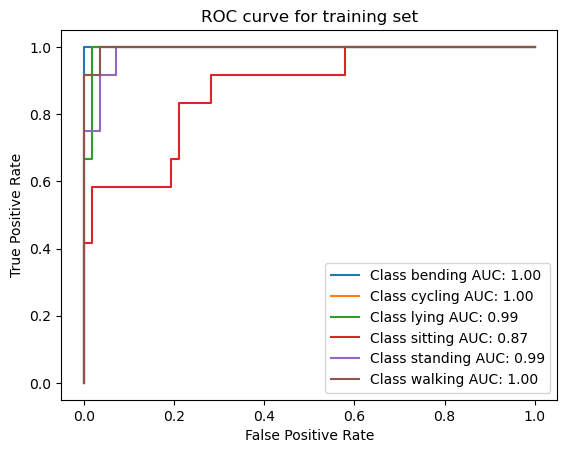

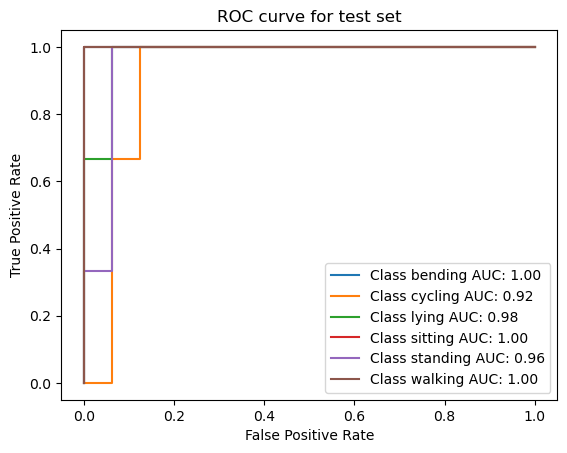

In [94]:
def perform_regression_with_cv(train_data_paths, test_data_paths, max_lvalue, is_binary_classification=True, classifier_type="logistic"):
    best_l = 0
    best_lambda = 0
    best_score = 0
    label_encoder = LabelEncoder()

    for l_value in range(1, max_lvalue + 1):
        train_set = generate_stats_of_lval(train_data_paths, l_value)
        test_set = generate_stats_of_lval(test_data_paths, l_value)

        if is_binary_classification:
            train_set = generate_binary_labels(pd.DataFrame(train_set)).astype(int)
            test_set = generate_binary_labels(pd.DataFrame(test_set)).astype(int)
        else:
            train_set['label'] = train_set['label'].replace(['bending1', 'bending2'], 'bending')
            test_set['label'] = test_set['label'].replace(['bending1', 'bending2'], 'bending')

            train_set["label"] = label_encoder.fit_transform(train_set["label"])
            test_set["label"] = label_encoder.transform(test_set["label"])
            

        trainX, trainY = split_predictors_and_response(train_set)
        testX, testY = split_predictors_and_response(test_set)
        
        if classifier_type == "logistic":
            multi_class_option = "ovr" if is_binary_classification else "multinomial"
            model = LogisticRegressionCV(cv=5, penalty="l1", solver="saga", max_iter=10000, multi_class=multi_class_option).fit(trainX, trainY)
            key = list(model.scores_.keys())[0]
            scores = model.scores_[key]
            lambdas = model.Cs_
            
            print(f"Running Cross-Validation for l-value {l_value}")
            for i, lambda_ in enumerate(lambdas):
                score = scores[:, i].mean()

                if score > best_score:
                    best_score = score
                    best_lambda = lambda_
                    best_l = l_value
        
        elif classifier_type == "gaussian" or classifier_type == "multinomial":
            if classifier_type == "gaussian":
                nb_model = GaussianNB()
            elif classifier_type == "multinomial":
                nb_model = MultinomialNB()
                
            cv_scores = cross_val_score(nb_model, trainX, trainY, cv=5)
            mean_cv_score = np.mean(cv_scores)
                
            print(f"Running Cross-Validation for l-value {l_value}")
                
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_l = l_value

    
    if classifier_type == "logistic":
        print(f"Best l-value: {best_l}, Best Lambda: {best_lambda}, Best Score: {best_score}")
    elif classifier_type == "gaussian" or classifier_type == "multinomial":
        print(f"Best l-value: {best_l}, Best Score: {best_score}")
    
    train_set_best = generate_stats_of_lval(train_data_paths, best_l)
    test_set_best = generate_stats_of_lval(test_data_paths, best_l)

    if is_binary_classification:
        train_set_best = generate_binary_labels(pd.DataFrame(train_set_best)).astype(int)
        test_set_best = generate_binary_labels(pd.DataFrame(test_set_best)).astype(int)
    else:
        train_set_best['label'] = train_set_best['label'].replace(['bending1', 'bending2'], 'bending')
        test_set_best['label'] = test_set_best['label'].replace(['bending1', 'bending2'], 'bending')

        train_set_best["label"] = label_encoder.fit_transform(train_set_best["label"])
        test_set_best["label"] = label_encoder.transform(test_set_best["label"])

    trainX_best, trainY_best = split_predictors_and_response(train_set_best)
    testX_best, testY_best = split_predictors_and_response(test_set_best)

    
    if classifier_type == "logistic":
        final_model = LogisticRegression(C=1/best_lambda, penalty="l1", solver="saga", max_iter=10000, multi_class=multi_class_option).fit(trainX_best, trainY_best)
    elif classifier_type == "gaussian" or classifier_type == "multinomial":
        if classifier_type == "gaussian":
            final_model = GaussianNB()
        elif classifier_type == "multinomial":
            final_model = MultinomialNB()
            
    final_model.fit(trainX_best, trainY_best)
    train_predictions = final_model.predict(trainX_best)
        
    train_predict_probability = final_model.predict_proba(trainX_best)
    test_predictions = final_model.predict(testX_best)
    test_predict_probability = final_model.predict_proba(testX_best)
    conf_matrix_train = confusion_matrix(trainY_best, train_predictions)
    conf_matrix_test = confusion_matrix(testY_best, test_predictions)
    
    print("confusion matrix for training set: \n",conf_matrix_train)
    print("confusion matrix for test set: \n",conf_matrix_test)
    if not is_binary_classification:
        fpr = dict()
        tpr = dict()
        for i in range(len(label_encoder.classes_)):
            fpr[i], tpr[i], _ = roc_curve(trainY_best == i, train_predict_probability[:, i])
            plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.inverse_transform([i])[0]} AUC: {auc(fpr[i], tpr[i]):.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.title("ROC curve for training set")
        plt.show()
        
        for i in range(len(label_encoder.classes_)):
            fpr[i], tpr[i], _ = roc_curve(testY_best == i, test_predict_probability[:, i])
            plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.inverse_transform([i])[0]} AUC: {auc(fpr[i], tpr[i]):.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.title("ROC curve for test set")
        plt.show()
        
perform_regression_with_cv(train_data_paths, test_data_paths, max_lvalue = 20, is_binary_classification=False, classifier_type="logistic")

#### ii. Naive Bayes

Results for gaussian:
Running Cross-Validation for l-value 1
Running Cross-Validation for l-value 2
Running Cross-Validation for l-value 3
Running Cross-Validation for l-value 4
Running Cross-Validation for l-value 5
Running Cross-Validation for l-value 6
Running Cross-Validation for l-value 7
Running Cross-Validation for l-value 8
Running Cross-Validation for l-value 9
Running Cross-Validation for l-value 10
Running Cross-Validation for l-value 11
Running Cross-Validation for l-value 12
Running Cross-Validation for l-value 13
Running Cross-Validation for l-value 14
Running Cross-Validation for l-value 15
Running Cross-Validation for l-value 16
Running Cross-Validation for l-value 17
Running Cross-Validation for l-value 18
Running Cross-Validation for l-value 19
Running Cross-Validation for l-value 20
Best l-value: 1, Best Score: 0.798901098901099
confusion matrix for training set: 
 [[ 8  0  1  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0

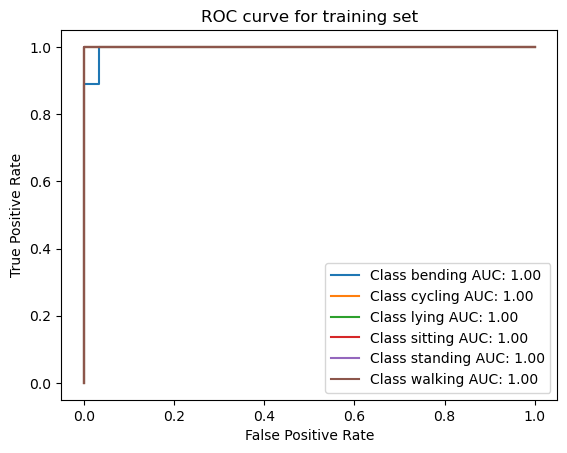

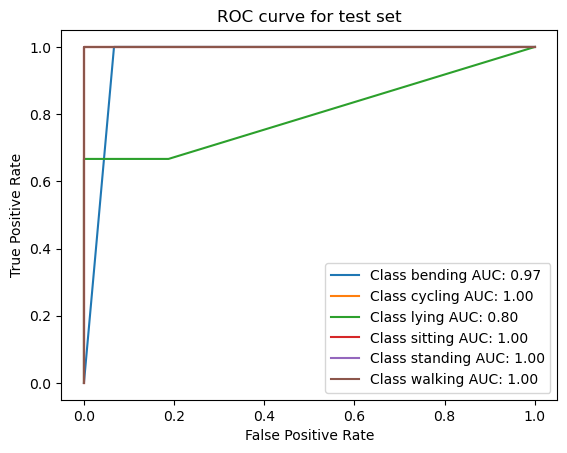

Results for multinomial:
Running Cross-Validation for l-value 1
Running Cross-Validation for l-value 2
Running Cross-Validation for l-value 3
Running Cross-Validation for l-value 4
Running Cross-Validation for l-value 5
Running Cross-Validation for l-value 6
Running Cross-Validation for l-value 7
Running Cross-Validation for l-value 8
Running Cross-Validation for l-value 9
Running Cross-Validation for l-value 10
Running Cross-Validation for l-value 11
Running Cross-Validation for l-value 12
Running Cross-Validation for l-value 13
Running Cross-Validation for l-value 14
Running Cross-Validation for l-value 15
Running Cross-Validation for l-value 16
Running Cross-Validation for l-value 17
Running Cross-Validation for l-value 18
Running Cross-Validation for l-value 19
Running Cross-Validation for l-value 20
Best l-value: 9, Best Score: 0.8252747252747253
confusion matrix for training set: 
 [[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  1 10  0  0]
 [ 0  0  0  1 1

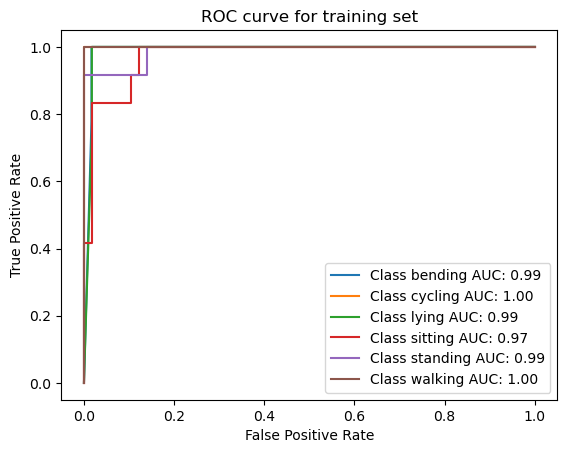

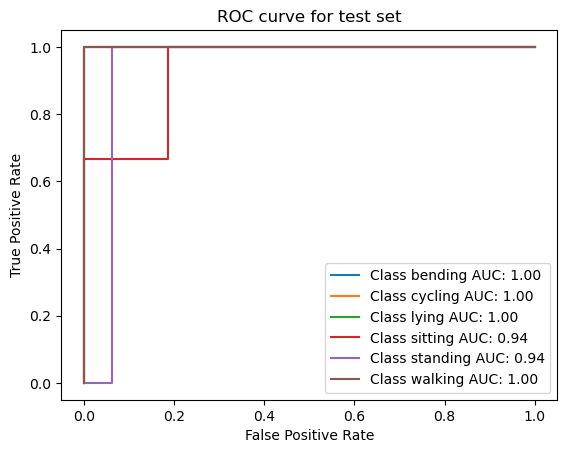

In [95]:
print("Results for gaussian:")
perform_regression_with_cv(train_data_paths, test_data_paths, 20, is_binary_classification=False, classifier_type="gaussian")

print("Results for multinomial:")
perform_regression_with_cv(train_data_paths, test_data_paths, 20, is_binary_classification=False, classifier_type="multinomial")

**Gaussian priors have a better result than multinomial priors. This is because gaussian prior classifier has less error based on confusion matrix when testing using test set**

#### ii. Comparison

In this multi classification problem, in terms of test error, naive bayes classifier with gaussian prior performs the best. The second is naive bayes classifier with multinomial prior. The last one is logistic regression with L1 regularization.

## 3. ISLR 4.8.3

### If you cannot see the image in github page, please refer to resources/4.8.3.jpg. It works fine in jupyter notebook and may be caused by the rendering issue of github pages. Thank you!
![ISLR 4.8.3](../resources/4.8.3.jpg)
![ISLR 4.8.3](https://github.com/DSCI-552/homework-4-Haoxiang310.git/resources/4.8.3.jpg)

## 4. ISLR 4.8.7

### If you cannot see the image in github page, please refer to resources/4.8.7.jpg. It works fine in jupyter notebook and may be caused by the rendering issue of github pages. Thank you!

![ISLR 4.8.7](../resources/4.8.7.jpg)
![ISLR 4.8.7](https://github.com/DSCI-552/homework-4-Haoxiang310.git/resources/4.8.7.jpg)

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9